#Homework 06

In [2]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import time

##1 Data set

Training inputs shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test inputs shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


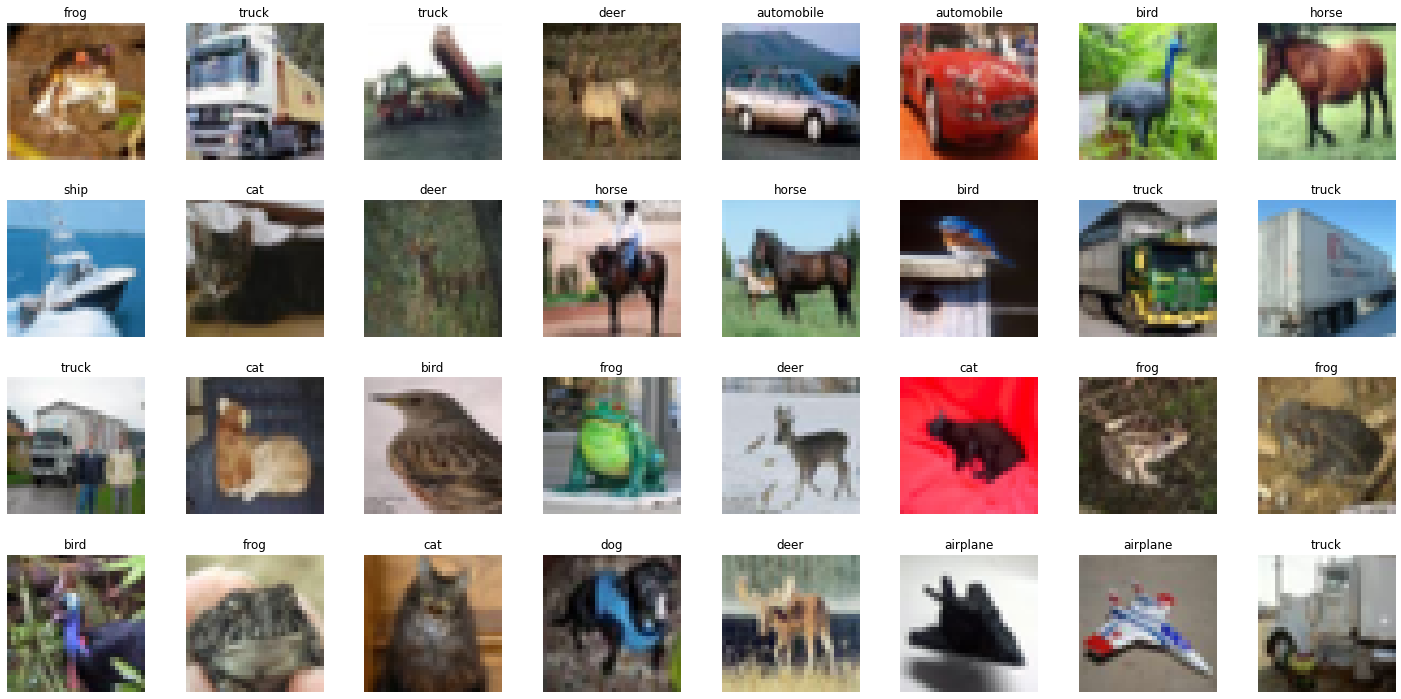

In [3]:
(training_inputs, training_labels), (test_inputs, test_labels) = tf.keras.datasets.cifar10.load_data()

print("Training inputs shape: " + str(training_inputs.shape))
print("Training labels shape: " + str(training_labels.shape))
print("Test inputs shape: " + str(test_inputs.shape))
print("Test labels shape: " + str(test_labels.shape))

label_encoding = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
fig, ax = plt.subplots(4, 8, figsize=(20,10))
fig.tight_layout()
ax = ax.flatten()
for i in range(32):
  image = training_inputs[i]
  label = label_encoding[training_labels[i][-1]]

  ax[i].imshow(image)
  ax[i].set_title(label)
  ax[i].axis("off")

In [4]:
batch_size = 64

# Creates tensorflow datasets for the training and test data.
train_dataset = tf.data.Dataset.from_tensor_slices((training_inputs, training_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels))

# Conducts the normalization of the inputs (images) and the one-hot-encoding of the targets.
train_dataset = train_dataset.map(lambda inp, tar: ((2*(inp/255)-1), tf.one_hot(tf.squeeze(tar), 10)))  # tf.squeeze(tar) to remove dimensions of size 1 from the shape of the target-tensors.
test_dataset = test_dataset.map(lambda inp, tar: ((2*(inp/255)-1), tf.one_hot(tf.squeeze(tar), 10)))     
                                                                                          
# Batches, shuffles and prefetches the training- and test datasets.
train_dataset = train_dataset.batch(batch_size).shuffle(buffer_size = batch_size).prefetch(128)
test_dataset = test_dataset.batch(batch_size).shuffle(buffer_size = batch_size).prefetch(128)

##2 Model

###2.1 ResNet

In [5]:
class ResidualBlock(tf.keras.layers.Layer):

  def __init__(self, filters):
    super(ResidualBlock,self).__init__()
    self.conv1 = tf.keras.layers.Conv2D(
        filters = filters,
        kernel_size = 1,
        activation = None,
        padding = 'same',
        kernel_initializer = tf.keras.initializers.glorot_normal,   
        bias_initializer = 'zeros',                                 
        kernel_regularizer = tf.keras.regularizers.L2(0.01)     
    )
    self.batchnorm1 = tf.keras.layers.BatchNormalization()
    self.activation1 = tf.keras.activations.relu
    self.conv2 = tf.keras.layers.Conv2D(
        filters = filters,
        kernel_size = 3,
        activation = None,
        padding = 'same',
        kernel_initializer = tf.keras.initializers.glorot_normal,   
        bias_initializer = 'zeros',                                 
        kernel_regularizer = tf.keras.regularizers.L2(0.01)
    )
    self.batchnorm2 = tf.keras.layers.BatchNormalization()
    self.activation2 = tf.keras.activations.relu
    self.conv3 = tf.keras.layers.Conv2D(
        filters = filters,
        kernel_size = 1,
        activation = None,
        padding = 'same',
        kernel_initializer = tf.keras.initializers.glorot_normal,   
        bias_initializer = 'zeros',                                 
        kernel_regularizer = tf.keras.regularizers.L2(0.01)
    )
    self.batchnorm3 = tf.keras.layers.BatchNormalization()
    self.activation3 = tf.keras.activations.relu
    
  @tf.function
  def call(self,x,training=True):
    y = self.conv1(x)
    y = self.batchnorm1(y)
    y = self.activation1(y)
    y = self.conv2(y)
    y = self.batchnorm2(y)
    y = self.activation2(y)
    y = self.conv2(y)
    y = self.batchnorm2(y)
    y = self.activation2(y)
    return (x + y)


In [6]:
class ResNet(tf.keras.Model):

  def __init__(self, num_blocks=2):
    super(ResNet,self).__init__()
    self.conv1 = tf.keras.layers.Conv2D(
        filters = 64,
        kernel_size = 3,
        activation = None,
        padding = 'same',
        input_shape = (32,32,3),
        kernel_initializer = tf.keras.initializers.glorot_normal,   
        bias_initializer = 'zeros',                                 
        kernel_regularizer = tf.keras.regularizers.L2(0.01)
    )
    self.batchnorm1 = tf.keras.layers.BatchNormalization()
    self.activation1 = tf.keras.activations.relu

    self.res_blocks = []
    for _ in range(num_blocks):
        self.res_blocks.append(ResidualBlock(filters=64))
    
    self.gloabl_pool = tf.keras.layers.GlobalAveragePooling2D()
    self.dense = tf.keras.layers.Dense(
        units = 10,
        activation = tf.keras.activations.softmax
    )

  @tf.function
  def call(self,x,training=True):
    x = self.conv1(x)
    x = self.batchnorm1(x,training)
    x = self.activation1(x)
    for res_block in self.res_blocks:
      x = res_block(x,training)
    x = self.gloabl_pool(x)
    x = self.dense(x)
    return x

###2.2 DenseNet

In [7]:
class TransitionLayer(tf.keras.layers.Layer):
  
  def __init__(self,filters):
    super(TransitionLayer,self).__init__()

    self.conv1 = tf.keras.layers.Conv2D(
        filters = filters,
        kernel_size = 1,
        activation = None,
        padding = 'same',
        kernel_initializer = tf.keras.initializers.glorot_normal,   
        bias_initializer = 'zeros',                                 
        kernel_regularizer = tf.keras.regularizers.L2(0.01)
    )
    self.batchnorm1 = tf.keras.layers.BatchNormalization()
    self.activation1 = tf.keras.activations.relu
    self.averagepooling1 = tf.keras.layers.AveragePooling2D(strides=(2,2),padding='same')
  
  def call(self,x,training=True):
    x = self.conv1(x)
    x = self.batchnorm1(x,training)
    x = self.activation1(x)
    x = self.averagepooling1(x)
    return x

In [8]:
class BuildingBlock(tf.keras.layers.Layer):

  def __init__(self,filters):
    super(BuildingBlock,self).__init__()

    self.batchnorm1 = tf.keras.layers.BatchNormalization()                                     
    self.activation1 = tf.keras.activations.relu
    self.conv1 = tf.keras.layers.Conv2D(
        filters = filters,
        kernel_size = 1,
        activation = None,
        padding = 'same',
        kernel_initializer = tf.keras.initializers.glorot_normal,   
        bias_initializer = 'zeros',                                 
        kernel_regularizer = tf.keras.regularizers.L2(0.01)
    )
    self.conv2 = tf.keras.layers.Conv2D(
        filters = filters,
        kernel_size = 3,
        activation = None,
        padding = 'same',
        kernel_initializer = tf.keras.initializers.glorot_normal,   
        bias_initializer = 'zeros',                                 
        kernel_regularizer = tf.keras.regularizers.L2(0.01)
    )
    self.batchnorm2 = tf.keras.layers.BatchNormalization()                                     
    self.activation2 = tf.keras.activations.relu
    self.concat = tf.keras.layers.Concatenate()             
        
  @tf.function 
  def call(self,x,training=True):
    y = self.batchnorm1(x,training)
    y = self.activation1(y)
    y = self.conv1(y)
    y = self.conv2(y)
    y = self.batchnorm2(y,training)
    y = self.activation2(y)
    output = self.concat([y,x])
    return output

In [9]:
class DenseBlock(tf.keras.layers.Layer):

  def __init__(self,filters_list):
    super(DenseBlock,self).__init__()

    self.conv_blocks = []
    for filters in filters_list:
      self.conv_blocks.append(BuildingBlock(filters))

  @tf.function
  def call(self,x,training=True):
    for conv_block in self.conv_blocks:
      x = conv_block(x,training)
    return x 

In [10]:
class DenseNet(tf.keras.Model):

  def __init__(self,dense_blocks_num,filters_list,growth_rate):
    super(DenseNet,self).__init__()
    
    conv_blocks_num = len(filters_list)
    
    self.conv1 = tf.keras.layers.Conv2D(
        filters = 32,
        kernel_size = 3,
        activation = None,
        padding = 'same',
        input_shape = (32,32,3),
        kernel_initializer = tf.keras.initializers.glorot_normal,   
        bias_initializer = 'zeros',                                 
        kernel_regularizer = tf.keras.regularizers.L2(0.01)
    )
    self.batchnorm1 = tf.keras.layers.BatchNormalization()
    self.activation1 = tf.keras.activations.relu
    self.dropout1 = tf.keras.layers.Dropout(rate=0.5)

    filters_transition_layer = conv_blocks_num * growth_rate

    self.dense_and_trans = []
    for i in range(dense_blocks_num - 1):
      self.dense_and_trans.append(DenseBlock(filters_list))
      self.dense_and_trans.append(TransitionLayer(filters_transition_layer))
    self.denseblock_last = DenseBlock(filters_list)

    self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
    self.dropout2 = tf.keras.layers.Dropout(rate=0.5)
    self.output_layer = tf.keras.layers.Dense(
        units = 10,
        activation = tf.keras.activations.softmax
    )

  @tf.function
  def call(self,x,training=True):
    x = self.conv1(x)
    x = self.batchnorm1(x,training)
    x = self.activation1(x)
    x = self.dropout1(x,training)

    for block in self.dense_and_trans:
      x = block(x,training)
    x = self.denseblock_last(x)

    x = self.global_pool(x)
    x = self.dropout2(x,training)
    x = self.output_layer(x)
    return x

##3 Training

In [11]:
def train_step(model, input, target, loss_function, optimizer, training=True):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape: #we safe the loss in the gradient tape 
    prediction = model(input, training)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function, training=False):
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input,training)
    sample_test_loss = loss_function(target, prediction).numpy()
    sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss)
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy


In [16]:
tf.keras.backend.clear_session()

residual_blocks_num = 5
model1 = ResNet(residual_blocks_num)

dense_blocks_num = 3
fiters_list =[32, 32, 32, 16, 8]
growth_rate = 10
model2 = DenseNet(dense_blocks_num, fiters_list, growth_rate)  

trainforNepochs = 30
learning_rate = 0.0001
running_average_factor = 0.95 
lossfunction = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate)

Epoch: 1 of 30. Time remaining: Unknown seconds
Epoch: 2 of 30. Time remaining: 1717.0 seconds
Epoch: 3 of 30. Time remaining: 1628.0 seconds
Epoch: 4 of 30. Time remaining: 1559.0 seconds
Epoch: 5 of 30. Time remaining: 1497.0 seconds
Epoch: 6 of 30. Time remaining: 1437.0 seconds
Epoch: 7 of 30. Time remaining: 1378.0 seconds
Epoch: 8 of 30. Time remaining: 1320.0 seconds
Epoch: 9 of 30. Time remaining: 1262.0 seconds
Epoch: 10 of 30. Time remaining: 1204.0 seconds
Epoch: 11 of 30. Time remaining: 1147.0 seconds
Epoch: 12 of 30. Time remaining: 1090.0 seconds
Epoch: 13 of 30. Time remaining: 1032.0 seconds
Epoch: 14 of 30. Time remaining: 975.0 seconds
Epoch: 15 of 30. Time remaining: 918.0 seconds
Epoch: 16 of 30. Time remaining: 860.0 seconds
Epoch: 17 of 30. Time remaining: 803.0 seconds
Epoch: 18 of 30. Time remaining: 745.0 seconds
Epoch: 19 of 30. Time remaining: 688.0 seconds
Epoch: 20 of 30. Time remaining: 631.0 seconds
Epoch: 21 of 30. Time remaining: 574.0 seconds
Epoch: 2

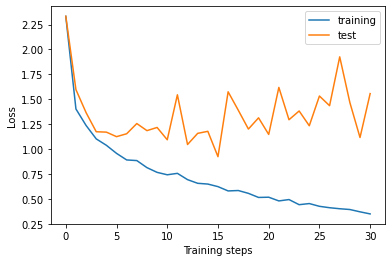

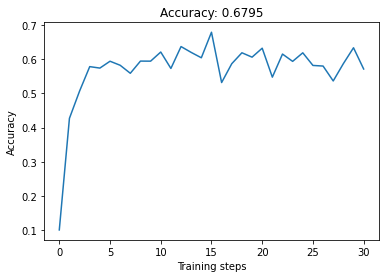

In [17]:
# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin, so that be have the first datapoints
test_loss, test_accuracy = test(model1, test_dataset, lossfunction)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin, so that we have a baseline
train_loss, _ = test(model1, train_dataset, lossfunction)
train_losses.append(train_loss)

# We train for trainforNepochs epochs.
for epoch in range(trainforNepochs):

    #just some fun runtime approximation that you can ignore :D
    if epoch == 0:              #before the first epoch we dont know how much time is going to pass.
      start = time.time()       #what we know is, when we started!
      time_remaining="Unknown"
    else:
      now = time.time()                                         
      time_per_epoch = ((now-start)/epoch)                      #average of the time per epoch
      remaining_epochs = trainforNepochs-epoch                  #numbers of remaining epochs
      time_remaining = round(time_per_epoch*remaining_epochs,0)
    print('Epoch:',str(epoch + 1 ),"of",str(trainforNepochs)+". Time remaining:", time_remaining, "seconds")





    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_dataset:                           #Training the model as long as we have training data
        train_loss = train_step(model1, input, target, lossfunction, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing how good the model performed in the current step
    test_loss, test_accuracy = test(model1, test_dataset, lossfunction)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

now = time.time()

print("Finished after",round(now-start,0),"seconds.")

# One plot training and test loss.

plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.title("Accuracy: " + str(np.round(np.max(test_accuracies),4)))
plt.show()

Epoch: 1 of 30. Time remaining: Unknown seconds
Epoch: 2 of 30. Time remaining: 1427.0 seconds
Epoch: 3 of 30. Time remaining: 1305.0 seconds
Epoch: 4 of 30. Time remaining: 1234.0 seconds
Epoch: 5 of 30. Time remaining: 1176.0 seconds
Epoch: 6 of 30. Time remaining: 1123.0 seconds
Epoch: 7 of 30. Time remaining: 1073.0 seconds
Epoch: 8 of 30. Time remaining: 1026.0 seconds
Epoch: 9 of 30. Time remaining: 979.0 seconds
Epoch: 10 of 30. Time remaining: 933.0 seconds
Epoch: 11 of 30. Time remaining: 887.0 seconds
Epoch: 12 of 30. Time remaining: 841.0 seconds
Epoch: 13 of 30. Time remaining: 796.0 seconds
Epoch: 14 of 30. Time remaining: 752.0 seconds
Epoch: 15 of 30. Time remaining: 707.0 seconds
Epoch: 16 of 30. Time remaining: 663.0 seconds
Epoch: 17 of 30. Time remaining: 618.0 seconds
Epoch: 18 of 30. Time remaining: 574.0 seconds
Epoch: 19 of 30. Time remaining: 530.0 seconds
Epoch: 20 of 30. Time remaining: 485.0 seconds
Epoch: 21 of 30. Time remaining: 441.0 seconds
Epoch: 22 of 

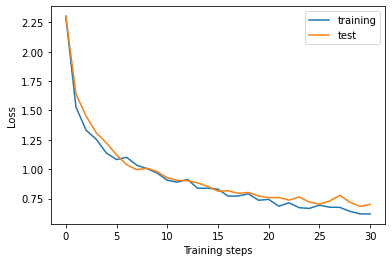

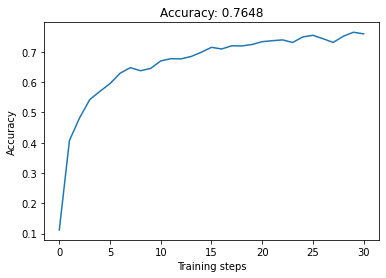

In [18]:
# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin, so that be have the first datapoints
test_loss, test_accuracy = test(model2, test_dataset, lossfunction)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin, so that we have a baseline
train_loss, _ = test(model2, train_dataset, lossfunction)
train_losses.append(train_loss)

# We train for trainforNepochs epochs.
for epoch in range(trainforNepochs):

    #just some fun runtime approximation that you can ignore :D
    if epoch == 0:              #before the first epoch we dont know how much time is going to pass.
      start = time.time()       #what we know is, when we started!
      time_remaining="Unknown"
    else:
      now = time.time()                                         
      time_per_epoch = ((now-start)/epoch)                      #average of the time per epoch
      remaining_epochs = trainforNepochs-epoch                  #numbers of remaining epochs
      time_remaining = round(time_per_epoch*remaining_epochs,0)
    print('Epoch:',str(epoch + 1 ),"of",str(trainforNepochs)+". Time remaining:", time_remaining, "seconds")





    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_dataset:                           #Training the model as long as we have training data
        train_loss = train_step(model2, input, target, lossfunction, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing how good the model performed in the current step
    test_loss, test_accuracy = test(model2, test_dataset, lossfunction)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

now = time.time()

print("Finished after",round(now-start,0),"seconds.")

# One plot training and test loss.

plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.title("Accuracy: " + str(np.round(np.max(test_accuracies),4)))
plt.show()

In [19]:
model1.summary()
model2.summary()

Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1792      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
residual_block (ResidualBloc multiple                  41600     
_________________________________________________________________
residual_block_1 (ResidualBl multiple                  41600     
_________________________________________________________________
residual_block_2 (ResidualBl multiple                  41600     
_________________________________________________________________
residual_block_3 (ResidualBl multiple                  41600     
_________________________________________________________________
residual_block_4 (ResidualBl multiple                  4160